You are welcomed to write your solution to the paper exercises here as well, so that they would be exported into the same PDF file. As a reminder, the text cells support Markdown, so it's easy to write TeX style equations, such as $f(x) = x^2$, here. 


# Data Preparation

Step 0: copy this Jupyter notebook to your own Google Drive so that you can edit it. 

Step 1: copy (i.e., add a shortcut of) hw1.zip from my Google Drive to yours, preferably to the folder TTIC31220-Winter21/ under the root of your Google Drive, which you should have done in Homework 1. 

Step 2: copy (i.e., create a shortcut of) the hw2/ folder from my Google Drive to yours, similarly as Step 1. 

Step 3: run the cell below to prepare data for your experiments. Note: once you close this page or the page says "disconnected", you will probably need to rerun the cell again, but you definitely don't need to rerun all probably time-consuming experiments.

In [42]:
from google.colab import files, drive
drive.mount('/content/drive')# follow the prompt to mount your Google Drive
! cp drive/MyDrive/TTIC31220-Winter21/hw1.zip ./hw1.zip
# Note: you might need to change the above path if hw1.zip is in a different 
#   folder in your Google drive. As a hint, your Google drive root folder is 
#   /content/drive/ or ./drive 
! unzip hw1.zip 
! cp drive/MyDrive/TTIC31220-Winter21/hw2/* ./

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  hw1.zip
replace data/noisy_two_view_distribute.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
# Below are libraries that I (Freda) used in my solution, you may find some of 
#   them not necessary, depending on libraries you imported and whatnot. You 
#   are not required to use all of them.

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn import decomposition
from numpy.random import permutation as rpm
from plot import plot_images, plot_embedding, plot_embedding_annotation
from dataset import read_mnist, read_mnist_twoview
from utils import resize, x2p, JacobOptimizer, gen_solution
from svm import linear_svm
from vae import VAE

# 3 Visualization of “Clean” MNIST 

## 3.1 Visualization with t-SNE

In [46]:
## TSNE
EPS=1.0e-12
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)


class LowEmb(nn.Module):
    """
        Computing t-SNE low-dim embedding
    """
    def __init__(self, n, d):
        """
          Input
            n: int, number of data points
            d: int, target dimensionality 
        """
        super(LowEmb, self).__init__()
        self.Y = nn.Embedding(n, d)
        

    def forward(self, P, dof, metric):
        """
          Compute similarity between distribution in low and high 
            dimensional space
        ------
          Input
            P: 2d-array of shape (n, n), distribution in high-dim space
            dof: float, degree of freedom of Student-t distribution
            metric: string, type of divergence
        """

        # Compute low-dim distribution Q
        Y = self.Y.weight
        
        Y2 = torch.sum(Y.pow(2), dim=1, keepdim=True)
        D = Y2 - 2 * Y.matmul(Y.t()) + Y2.t()
        Q = (1 - torch.eye(Y.shape[0]).type_as(D)) * (1 + D/dof).pow(
            -(dof + 1)/2.0)
        Q = (Q/Q.sum()).clamp_(min=EPS)

        # Compute discrepency between P and Q
        if metric == 'KL':
            C = torch.sum(P*torch.log(P/Q))
        elif metric == 'DIS':
            # TODO, optional for 3.1.2 (a) (add your code below): 
            #     define your own metric
            C = torch.sum((P-Q).pow(2)).pow(0.5)*100
            # TODO (add you code above)
        else:
             C = torch.sum(Q*torch.log(Q/P))

        
        return C


class TSNE(object):
    """
    Main Module of t-SNE
    Parameters:
    ------ 
    n_components: int, dimension to reduce to (default: 2)
    perplexity: float, perplexity of data in high-dimensional space 
        (default: 30)
    n_iters: int, number of iterations for optimization (default: 1000)
    lr: float, learning rate (default: 100)
    optimizer: string, type of optimizer
        "Jacob" | "Adam" | "SGD" | "RMSprop" | "Adagrad" | "Adadelta" 
        (default: "Jacob")
    cuda: bool, whether to use GPU if available (default: True)
    dof: float, degree of freedom of Student-t distribution (default: 1.0)
    metric: string, type of divergence between high and low dimensional space 
        (default: "KL")
    early_exaggeration: float, constant to multiply to high dimensional 
        probability, used in early stages of optimization to exaggerate the 
        divergence between low and high dimensional space. See the original 
        t-SNE paper for details (default: 4)
    early_iters: int, number of iterations to do early exaggeration 
        (default: 100)
    log_interval: int, iteration interval to show error (default: 100)
    init: string, initialization of low-dimensional embedding. 
        Possible options are "random" | "pca" (default: "pca")

    """
    def __init__(self, n_components=2, perplexity=30.0, n_iters=1000, lr=1.0e2, 
                 optimizer='Jacob', cuda=True, dof=1.0, metric='KL', 
                 early_exaggeration=4., early_iters=100, log_interval=100, 
                 init='pca'
            ):

        self.n_iters = n_iters
        self.lr = lr
        self.optimizer = optimizer
        self.n_components = n_components
        self.perplexity = perplexity
        self.device = torch.device(
            'cuda' if cuda and torch.cuda.is_available() else 'cpu'
        )
        self.dof = dof
        self.metric = metric
        self.early_exaggeration = early_exaggeration
        self.early_iters = early_iters
        self.log_interval = log_interval
        self.init = init

    def fit_transform(self, X):
        """
        Run t-SNE on X
        ------
        Input
            X: 2d array of shape (n_data, n_dim)
        Output
            Y: 2d array of shape (n_data, n_components)
        """
        print("Metric: %s" % (self.metric))

        # Compute high-dim distribution matrix P
        P = x2p(X, perplexity=self.perplexity)
        P = (P + P.T) / (2*P.sum())

        # early exageration, P *= Const
        P = P if self.early_exaggeration is None \
                else P * self.early_exaggeration
        P = torch.from_numpy(P.clip(EPS)).type(torch.float)

        lowEmb = LowEmb(X.shape[0], self.n_components)
        
        # PCA intialization (optional)
        if self.init == 'pca':
            lowEmb.Y.weight.data.copy_(torch.from_numpy(self.pca(X)))

        lowEmb.to(self.device)
        P = P.to(self.device)
        if self.optimizer == 'Jacob':
            optimizer = JacobOptimizer(lowEmb.parameters(), lr=self.lr)
        elif hasattr(torch.optim, self.optimizer):
            optimizer = getattr(torch.optim, self.optimizer)(
                lowEmb.parameters(), lr=self.lr
            )
        else:
            raise AttributeError(
                'Valid options for optimizer are '
                '[Jacob, Adam, SGD, RMSprop, Adagrad, Adadelta].'
            )

        # Optimization
        for iter in range(self.n_iters):
            lowEmb.zero_grad()
            l = lowEmb(P, dof=self.dof, metric=self.metric)
            l.backward()
            optimizer.step()
            if (iter + 1) % self.log_interval == 0:
                print("Iteration %d, error: %f" % (iter + 1, l))
            # Stop early exaggeration, use true P value
            if iter == self.early_iters and self.early_exaggeration is not None:
                P = P/self.early_exaggeration
        Y = lowEmb.Y.weight.cpu().detach().numpy()

        return Y

    def pca(self, X):
        """
        Perform PCA on X, as optional preprocessing step
        ------
        Input 
            X: 2d array of shape (n_data, n_dim)
        Output
            Y: 2d array of shape (n_data, n_components)
        """
        Y = decomposition.PCA(
            n_components=self.n_components).fit_transform(X).astype(np.float32)
        return Y

### Load and visualize some data
As you might have found, we would like to make sure we're loading the data correctly.


Data path is: ./data/original_distribute.mat


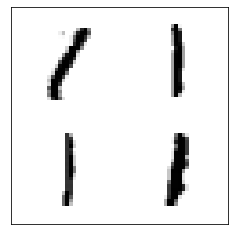

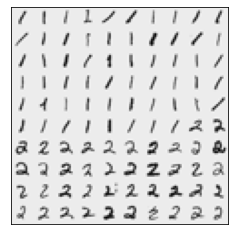

In [49]:
np.random.seed(0)


datapath="./data/original_distribute.mat"
print("Data path is: %s" % datapath)

trainData,devData,testData=read_mnist(datapath)
test_x_sample = testData
test_x_image = np.reshape(
    test_x_sample, [test_x_sample.shape[0],28,28]).transpose(0, 2, 1)
train_x_sample = trainData.images
train_x_image = np.reshape(
    train_x_sample, [train_x_sample.shape[0],28,28]).transpose(0, 2, 1)
train_y_sample = np.reshape(trainData.labels, [train_x_sample.shape[0]])
dev_x_sample = devData.images
dev_x_image = np.reshape(
    dev_x_sample, [dev_x_sample.shape[0],28,28]).transpose(0, 2, 1)
dev_y_sample = np.reshape(devData.labels, [dev_x_sample.shape[0]])


"""
1. Visualize a few input digits
plot_images: Plot a list of selected digits
"""
plot_images(train_x_image[::1500], 2, 2, 28, 28)



"""
2. Visualize more input digits, using smaller scale
"""

train_x_rescale = resize(train_x_image,10,10)
ax = plot_images(train_x_rescale[::100], 10, 10, 10, 10)
plt.show()


### Visualization of 20% MNIST dev data

Start TSNE!
Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 10.947906
Iteration 200, error: 1.259665
Iteration 300, error: 1.158653
Iteration 400, error: 1.098659
Iteration 500, error: 1.073381


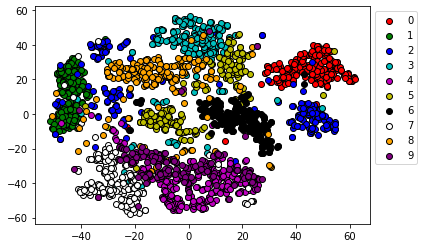

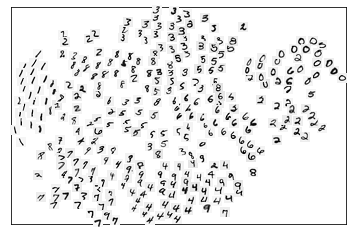

In [12]:
print("Start TSNE!")
z_tsne_dev = TSNE(
        n_components=2, perplexity=30, n_iters=500, cuda=True, dof=1.0, 
        metric="KL", early_exaggeration=4, init='pca'
    ).fit_transform(dev_x_sample[::5])
plot_embedding(z_tsne_dev, dev_y_sample[::5])
plot_embedding_annotation(z_tsne_dev, resize(dev_x_image[::5],10,10), 0.001)
plt.show()

### 3.1.1 (TODO) Add your hyperparameter tuning experiments below



perplexity is 10

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 12.685634
Iteration 200, error: 1.600253
Iteration 300, error: 1.402823
Iteration 400, error: 1.280184
Iteration 500, error: 1.223341


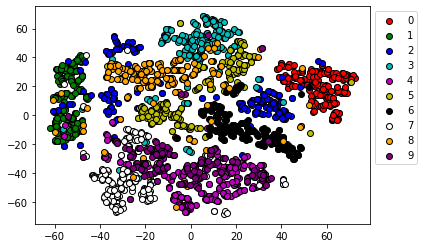

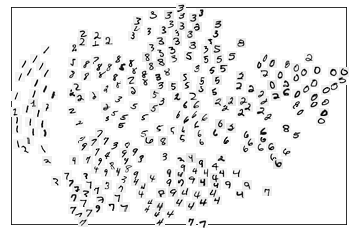

perplexity is 50

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 10.263365
Iteration 200, error: 1.119942
Iteration 300, error: 1.054603
Iteration 400, error: 1.018536
Iteration 500, error: 1.002503


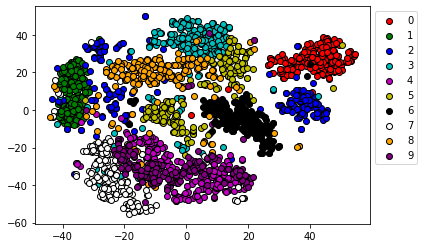

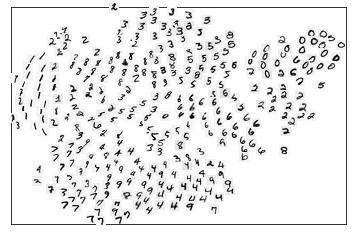

perplexity is 100

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 9.440748
Iteration 200, error: 0.944051
Iteration 300, error: 0.916571
Iteration 400, error: 0.904321
Iteration 500, error: 0.900348


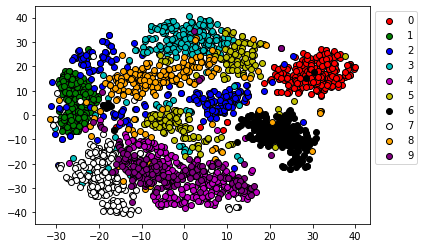

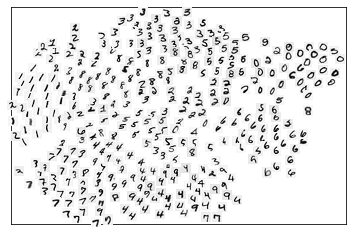

perplexity is 200

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 8.745266
Iteration 200, error: 0.790577
Iteration 300, error: 0.784255
Iteration 400, error: 0.782486
Iteration 500, error: 0.781962


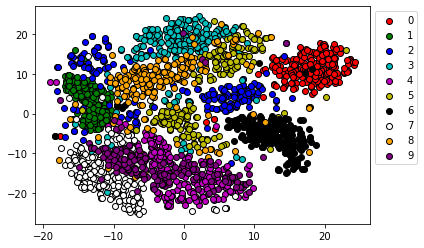

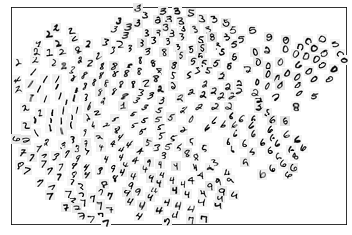

perplexity is 300

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 8.326231
Iteration 200, error: 0.689904
Iteration 300, error: 0.687572
Iteration 400, error: 0.687153
Iteration 500, error: 0.687123


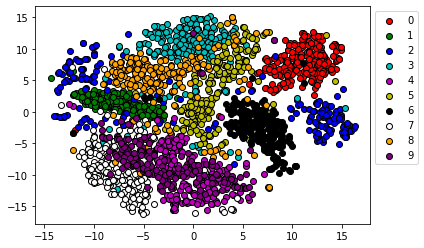

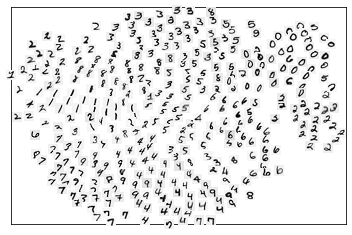

perplexity is 500

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 7.780459
Iteration 200, error: 0.558435
Iteration 300, error: 0.558392
Iteration 400, error: 0.558391
Iteration 500, error: 0.558391


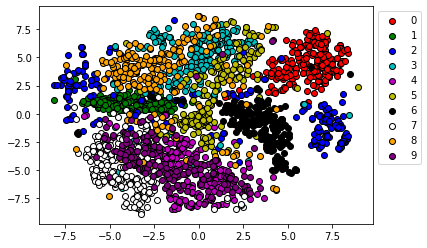

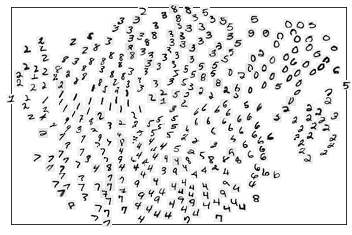

perplexity is 700

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 7.346221
Iteration 200, error: 0.449743
Iteration 300, error: 0.449243
Iteration 400, error: 0.448398
Iteration 500, error: 0.448381


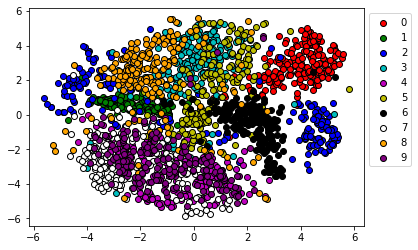

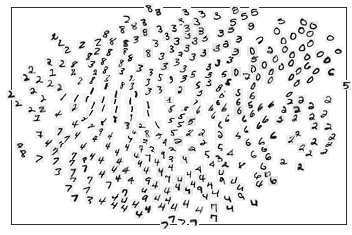

In [50]:
perplexity_list = [10,50,100,200,300,500,700]
for perp in perplexity_list:
  print(f"perplexity is {perp}\n")
  z_tsne_dev = TSNE(
        n_components=2, perplexity=perp, n_iters=500, cuda=True, dof=1.0, 
        metric="KL", early_exaggeration=4, init='pca'
    ).fit_transform(dev_x_sample[::5])
  plot_embedding(z_tsne_dev, dev_y_sample[::5])
  plot_embedding_annotation(z_tsne_dev, resize(dev_x_image[::5],10,10), 0.001)
  plt.show()

### Answers to 3.1.1

The error reported by different perplexity fit the trend that the larger the perplexity, the lower error is. However, from visualization result, the lower error does not necessarily indicate a better visualization from my perspective.

Comparing the visualization result of perplexity = 700 and the result of perplexity = 300, the error for perplexity =700 is 0.44 and the error for perplexity= 300 is 0.68. However, since more details was captured when perplxity = 700, groups of small cluster formed instead of a big cluster (see digit 9) and did a worse job in discriminating digit 4 and digit 9. 

### 3.1.2 (TODO) Add your code for extra discrepancy measure above, or add your DoF-tuning experiments below
Again, you may do both for extra credits. 

perplexity is 10
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 3.800865
Iteration 200, error: 0.931225
Iteration 300, error: 0.879647
Iteration 400, error: 0.743416
Iteration 500, error: 0.640027


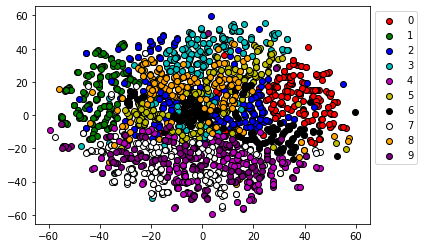

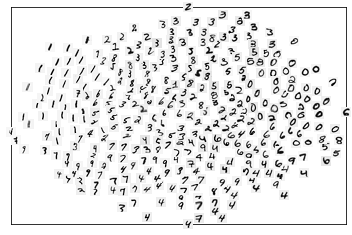

perplexity is 50
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 2.117403
Iteration 200, error: 0.501897
Iteration 300, error: 0.452544
Iteration 400, error: 0.366923
Iteration 500, error: 0.316459


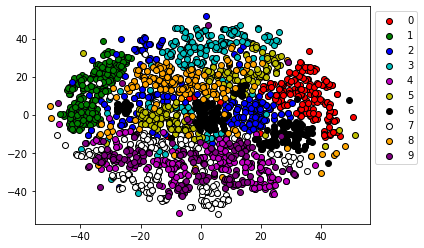

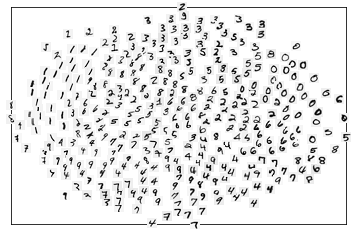

perplexity is 100
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 1.580555
Iteration 200, error: 0.365077
Iteration 300, error: 0.324111
Iteration 400, error: 0.268568
Iteration 500, error: 0.239851


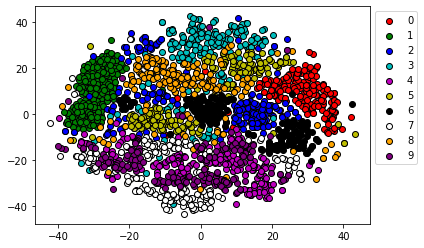

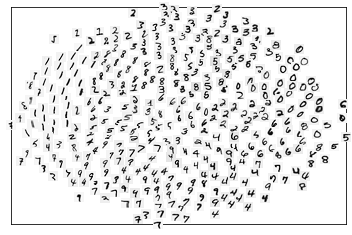

perplexity is 200
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 1.123660
Iteration 200, error: 0.250298
Iteration 300, error: 0.221470
Iteration 400, error: 0.195515
Iteration 500, error: 0.185615


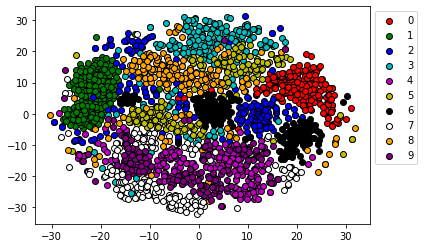

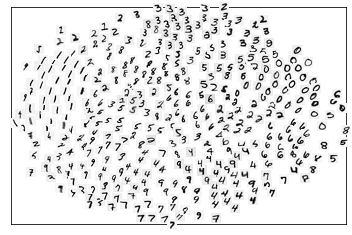

perplexity is 300
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 0.887661
Iteration 200, error: 0.192455
Iteration 300, error: 0.172718
Iteration 400, error: 0.160553
Iteration 500, error: 0.157351


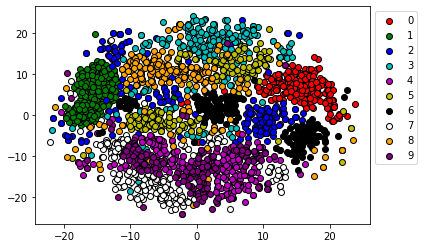

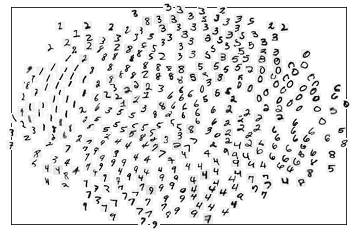

perplexity is 400
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 0.733837
Iteration 200, error: 0.155571
Iteration 300, error: 0.142689
Iteration 400, error: 0.137268
Iteration 500, error: 0.136313


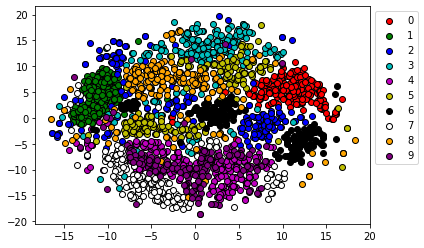

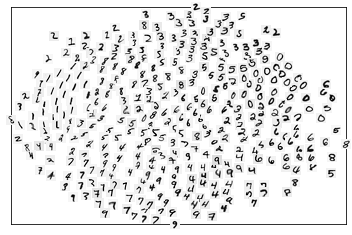

perplexity is 500
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 0.622515
Iteration 200, error: 0.130009
Iteration 300, error: 0.121824
Iteration 400, error: 0.119323
Iteration 500, error: 0.119024


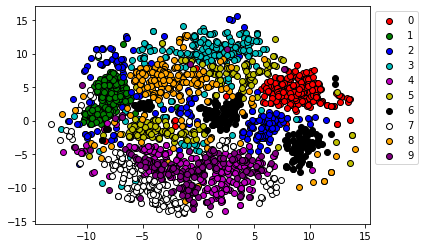

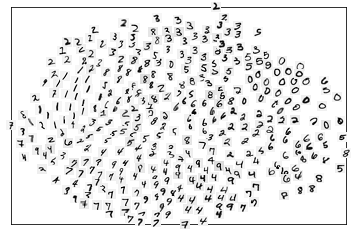

perplexity is 600
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 0.537057
Iteration 200, error: 0.111220
Iteration 300, error: 0.106426
Iteration 400, error: 0.105031
Iteration 500, error: 0.104762


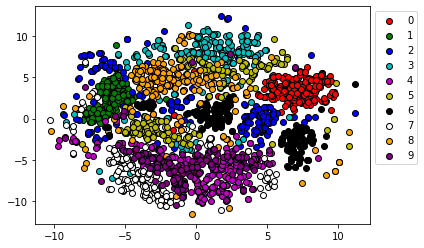

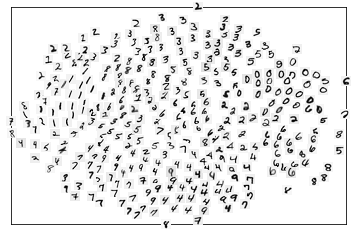

perplexity is 700
Metric: DIS
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 0.468903
Iteration 200, error: 0.096463
Iteration 300, error: 0.093972
Iteration 400, error: 0.093202
Iteration 500, error: 0.093002


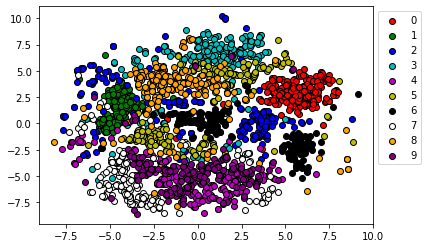

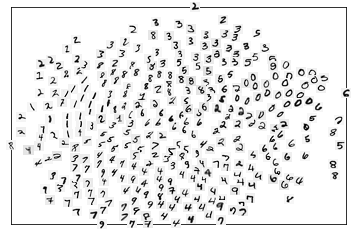

In [23]:
perplexity_list = [10,50,100,200,300,400,500,600,700]
for perp in perplexity_list:
  print(f"perplexity is {perp}")
  z_tsne_dev = TSNE(
        n_components=2, perplexity=perp, n_iters=500, cuda=True, dof=1.0, 
        metric="DIS", early_exaggeration=4, init='pca'
    ).fit_transform(dev_x_sample[::5])
  plot_embedding(z_tsne_dev, dev_y_sample[::5])
  plot_embedding_annotation(z_tsne_dev, resize(dev_x_image[::5],10,10), 0.001)
  plt.show()

### 3.1.2(a) Comment to self implemented divergence

Different diversion implementation:
The distance between two joint probility:
$100*\sqrt{\sum_i\sum_j(P_{i,j}-Q_{i,j})^2}$
The reason it was multiplied by 100, a constant, simply because the error is too small.

The t-SNE with new divergence is able to visualize the high-dimensional result. However, from my perspective, the new divergence performed worse than KL divergence, specifically was not able to group digits such as 6 and 5 to one large group like what t-SNE with KL divergence achieved. The distance t-SNE seperated digit 5 and digit 6 groups into two groups.

dof is 1

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 10.263819
Iteration 200, error: 1.119857
Iteration 300, error: 1.054664
Iteration 400, error: 1.018758
Iteration 500, error: 1.002709


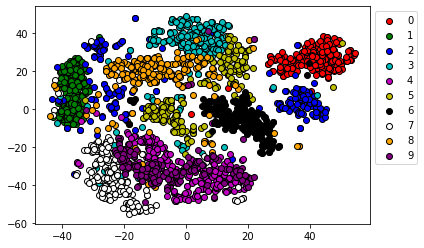

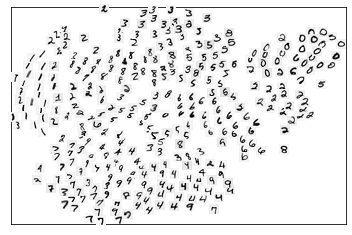

dof is 6

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 11.854807
Iteration 200, error: 1.577347
Iteration 300, error: 1.577306
Iteration 400, error: 1.577306
Iteration 500, error: 1.577306


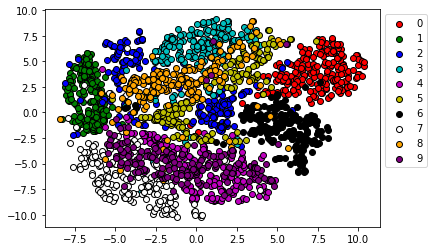

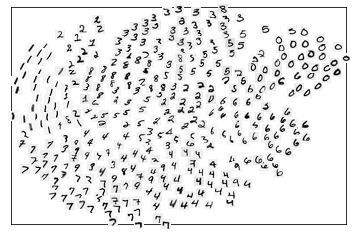

dof is 11

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 12.509392
Iteration 200, error: 1.701579
Iteration 300, error: 1.700884
Iteration 400, error: 1.700884
Iteration 500, error: 1.700884


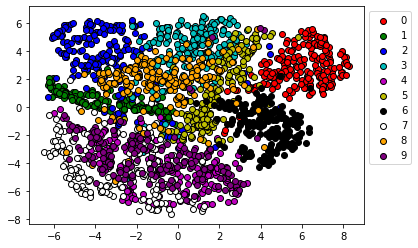

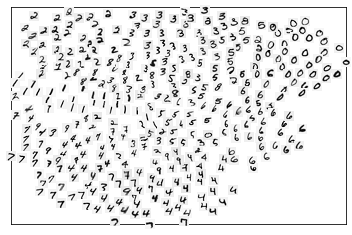

dof is 16

Metric: KL
Computing Gaussian for point 0 of 2000...
Computing Gaussian for point 1000 of 2000...
Gaussian for 2000 points done
Iteration 100, error: 12.788174
Iteration 200, error: 1.779078
Iteration 300, error: 1.779014
Iteration 400, error: 1.779014
Iteration 500, error: 1.779014


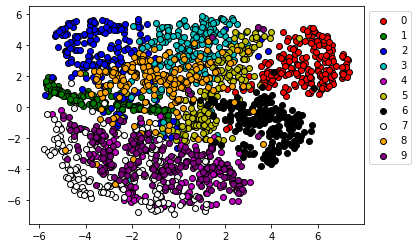

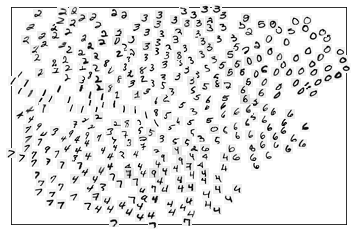

In [25]:
dof_list = [i for i in range(1,20,5)]
for dof in dof_list:
  print(f"dof is {dof}\n")
  z_tsne_dev = TSNE(
        n_components=2, perplexity=50, n_iters=500, cuda=True, dof=dof, 
        metric="KL", early_exaggeration=4, init='pca'
    ).fit_transform(dev_x_sample[::5])
  plot_embedding(z_tsne_dev, dev_y_sample[::5])
  plot_embedding_annotation(z_tsne_dev, resize(dev_x_image[::5],10,10), 0.001)
  plt.show()

###Answer to 3.1.2(b) Change of DOF:

From the visualization graph, as the DOF increased, the plot was more spread out did not have a strong clusters. It matches with the expectation as the DOF increased, the t-distribution's tail is less heavy, thus the moderately distant points cannot be grouped, therefore make the cluster spread out. 

## 3.2 Visualization with Other Dimensionality Reduction Techniques



### Answer to 3.2.1:
Laplacian eigenmaps

Input: 
1. Data matrix 
2. Neighboring cutoff to determine if two data points are neighbors, eps
3. Tunning parameter, T

Output: Eigenvectors of the grapha laplacian matrix

The problem optimized: Points who are neighbors should be close by in projected dimension.

Assuming each data point is a node in the graph and there exist an edge in between the nodes if two nodes are neighbors.

First, assign weights to the edge of the graph, to form matrix W which follows the following rule: \\
  if the euclidean distance between two data points are smaller than eps,$||x_i-x_j|| < eps$ assign: $\exp{(-||x_i-x_j||^2/t)}$; otherwise, 0.

Second, calculate diagonal matrix D where $D_{ii} = \sum_j W_{i,j}$

Third, calculate Laplacian matrix L where $L=I-D^{1/2}*W*D^{1/2}$

Fourth, calculate eigenvectors of L.

The $D^{1/2}$ is implemented as  $D_{ii}^{1/2} = \sum_j W_{i,j}^{1/2}$ 

### 3.2.2 (TODO) Implement the dimensionality reduction technique of your own choice below

You should be fine by filling in the "blanks", but feel free to change the input and output of the function. 

In [129]:
def my_visualize_emb(data,eps=15,t = 30):
    """
    Input
        data: 2d array of shape (n_data, n_dim), training data 
    Output
        features: 2d array of shape (n_data, 2), 2-d feature in the 
            low-dimensional space
    """
    #eps: the cutoff to determine whether two points are neighbors
    #t: the tunning parameter
    features = np.zeros(data[:, :2].shape)
    # TODO (add your code below)


    data2 = np.sum(data**2, axis=1, keepdims=True)
    Dis2 = (data2 - 2 * data.dot(data.T) + data2.T).clip(0)
    Dis = Dis2**0.5
    mask = Dis>eps
    W = np.exp(-Dis2/t)
    W[mask] = 0
    D = (W.sum(axis=1))**(-0.5)
    dia = np.diag(D)
    L = np.identity(W.shape[0]) - dia.dot(W).dot(dia)
    eigenValues, eigenVectors = np.linalg.eig(L)
    idx = eigenValues.argsort()   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    features = eigenVectors[:,:2]



    # (add your code above)
    return features

### 3.2.3 (TODO) Add your experiments below

15


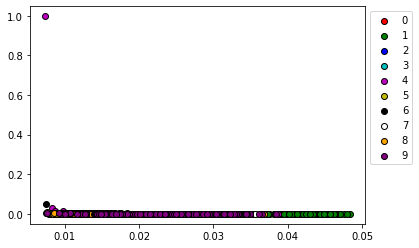

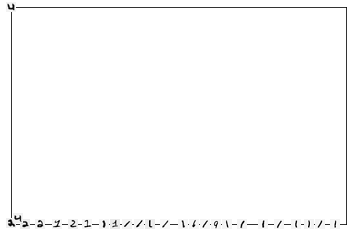

20


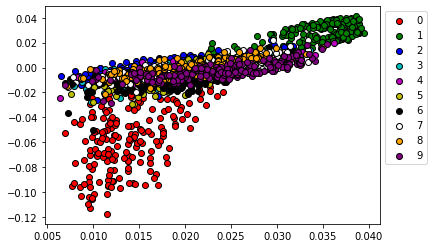

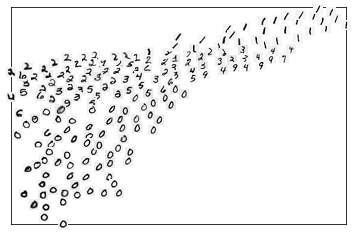

25


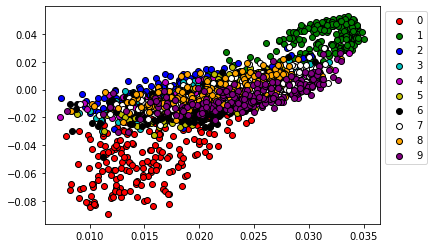

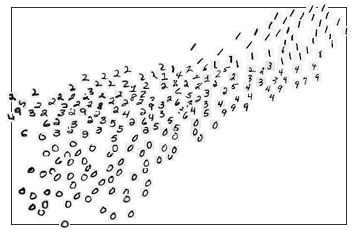

30


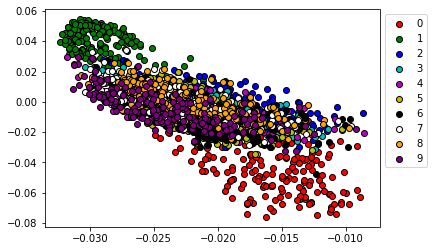

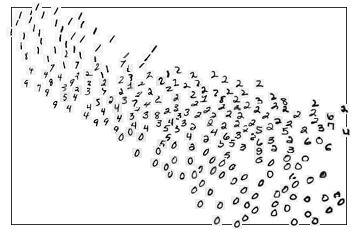

In [128]:
t_list = [15,20,25,30]
for t in t_list:
    print(t)
    z_my_dev = my_visualize_emb(dev_x_sample[::5],t =t)
    plot_embedding(z_my_dev, dev_y_sample[::5])
    plot_embedding_annotation(z_my_dev, resize(dev_x_image[::5],10,10), 0.001)
    plt.show()

Start My Method!


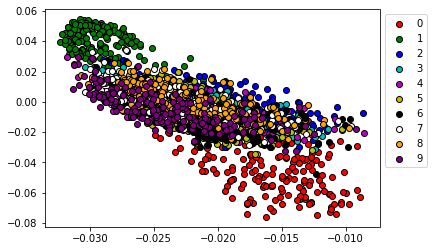

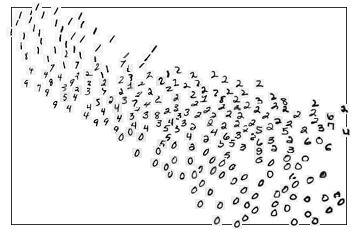

In [130]:
print("Start My Method!")
z_my_dev = my_visualize_emb(dev_x_sample[::5])
plot_embedding(z_my_dev, dev_y_sample[::5])
plot_embedding_annotation(z_my_dev, resize(dev_x_image[::5],10,10), 0.001)
plt.show()

### Answer to 3.2.4:

Two parameters is required for implement laplacian eigenmaps, one is the neighbors cutoff and the tunning parameter. The neighbors cutoff is to use the maximum difference between two datapoints within the same group. Therefore not a hyperparameter.

The only hyperparameter to tune is the tuning parameter T. The visualizing result did not change when T < 20 as there exist an outlier point which squeeze the rest of the points to a line. The visualizing result also did not change much when T > 30.

From the visualizing plot generated. It is clearly noted the laplacian eigenmaps is able to differentiate digit 0 and digit 1. However, the rest of the digits mixed altogether. Digit 4 and digit 2 is at the opposite end of this big groups and digit 8 is at the middle of this big groups. 

For this problem, the laplacian eigenmaps did not performed well on this dataset. And the hyperparameter really works to assign higher weights to points that are not closely connected. Therefore, reduce the effect on those points are tightly connected. 



### Answer to 3.2.5

Conventional PCA is able to generate model from one dataset and apply projection to another dataset.

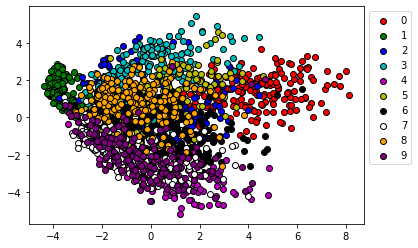

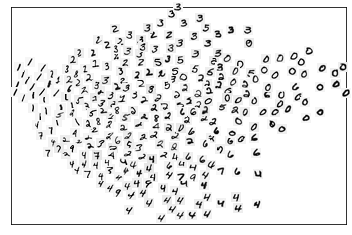

In [5]:
pca_1 = decomposition.PCA(n_components=2)
pca_1.fit(dev_x_sample[::10])
z_my_dev=pca_1.transform(dev_x_sample[::5])
plot_embedding(z_my_dev, dev_y_sample[::5])
plot_embedding_annotation(z_my_dev, resize(dev_x_image[::5],10,10), 0.001)
plt.show()

# 4 Digit Classification on the “Noisy” MNIST Dataset 

## 4.1 Variational Autoencoders

In [5]:
def vae_emb(train_subset, dev_subset, train_data, dev_data, test_data, 
            n_components, lr=1.0e-3, batch_size=128,
            epochs=15, kkl=1.0, kv=1.0, path='VAE.pt'
        ):
    """
    Train and extract feature with VAE
    ------
    Input
        train_subset, dev_subset: 2d array of shape (n_data, n_dim), VAE 
            training and development data
        train_data, dev_data, test_data: 2d array of shape (n_data, n_dim), 
            training/dev/test set of the dataset, where trained VAE will be 
            used to extract features
        n_components: int, feature dimension
        lr: float, learning rate (default: 0.001)
        batch_size: int, batch size to train VAE (default: 128)
        epochs: int, training epochs (default: 20)
        kkl: float, weight (lambda_KL) on -KL(q(z|x)||p(z)) (default: 1.0)
        kv: float, weight (lambda_var) on variance term inside -KL(q(z|x)||p(z)) 
            (default: 1.0)
        path: string, path to save trained model (default: "VAE.pt")
    
    Output
        train_features, dev_features, test_features: 2d array of shape 
            (n_data, n_dim), extracted features of the training/dev/test set
    """
    print("Using VAE")
    model = VAE(
        n_inputs=train_subset.shape[1], 
        n_components=n_components, 
        lr=lr, 
        batch_size=batch_size, 
        kkl=kkl, 
        kv=kv, 
        path=path
    )
    model.fit(train_subset, Xd=dev_subset, epochs=epochs)
    train_features = model.transform(train_data)
    dev_features = model.transform(dev_data)
    test_features = model.transform(test_data)
    return train_features, dev_features, test_features


In [6]:
datapath="./data/noisy_distribute.mat"
print("Data path is: %s" % datapath)

trainData, devData, testData = read_mnist(datapath)
test_x_noisy = testData
train_x_noisy = trainData.images
train_y_noisy = np.reshape(trainData.labels, -1)
dev_x_noisy = devData.images
dev_y_noisy = np.reshape(devData.labels, -1)

# train VAE
n_samples = 10000
z_vae_train, z_vae_dev, z_vae_test = vae_emb(
    train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]], dev_x_noisy,
    train_x_noisy, dev_x_noisy, test_x_noisy, n_components=20
)


# Uncomment following 3 lines if to use 10% labeled set for faster tuning
# best_error_dev, pred = linear_svm(
#    z_vae_train[::10], train_y_noisy[::10], z_vae_dev, dev_y_noisy, z_vae_test
# )

best_error_dev, pred = linear_svm(
    z_vae_train, train_y_noisy, z_vae_dev, dev_y_noisy, z_vae_test
)

Data path is: ./data/noisy_distribute.mat
Using VAE
Epoch: 1, train loss: 261.4131, dev loss: 204.4460
Epoch: 2, train loss: 188.0158, dev loss: 178.0021
Epoch: 3, train loss: 168.1271, dev loss: 163.7992
Epoch: 4, train loss: 156.6795, dev loss: 154.0957
Epoch: 5, train loss: 149.0404, dev loss: 148.1787
Epoch: 6, train loss: 144.4853, dev loss: 144.3081
Epoch: 7, train loss: 140.8076, dev loss: 141.5727
Epoch: 8, train loss: 138.2238, dev loss: 139.2496
Epoch: 9, train loss: 136.5169, dev loss: 137.7611
Epoch: 10, train loss: 134.7344, dev loss: 136.4644
Epoch: 11, train loss: 133.3522, dev loss: 134.9829
Epoch: 12, train loss: 132.1001, dev loss: 134.0319
Epoch: 13, train loss: 131.0936, dev loss: 133.0260
Epoch: 14, train loss: 130.3916, dev loss: 132.3822
Epoch: 15, train loss: 129.4481, dev loss: 132.1238
Performing linear SVM!
C = 0.010000, dev error = 0.269400
C = 0.100000, dev error = 0.267100
C = 1.000000, dev error = 0.267000
Selected classifier with best dev error 0.267000


### 4.1.1 (TODO) Add you experiments for tuning $\lambda_\textit{KL}$ and $\lambda_{var}$ below

In [9]:
kkl_list = np.logspace(-2,3,5)
kv_list = np.logspace(-2,3,5)

In [15]:
kkl_list = np.logspace(-2,3,5)
kv_list = np.logspace(-2,3,5)
for kkl in kkl_list:
  for kv in kv_list:
    print(kkl,kv)
    n_samples = 10000
    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]], dev_x_noisy,
        train_x_noisy, dev_x_noisy, test_x_noisy, n_components=20,
        kkl=kkl, kv=kv
    )


    #Uncomment following 3 lines if to use 10% labeled set for faster tuning
    best_error_dev, pred = linear_svm(
       z_vae_train[::10], train_y_noisy[::10], z_vae_dev, dev_y_noisy, z_vae_test
    )

0.01 0.01
Using VAE
Epoch: 1, train loss: 241.2040, dev loss: 176.6964
Epoch: 2, train loss: 150.7940, dev loss: 135.5107
Epoch: 3, train loss: 123.7100, dev loss: 118.6069
Epoch: 4, train loss: 111.2727, dev loss: 109.5734
Epoch: 5, train loss: 104.7146, dev loss: 104.8611
Epoch: 6, train loss: 101.1917, dev loss: 102.4534
Epoch: 7, train loss: 98.4784, dev loss: 100.1585
Epoch: 8, train loss: 96.6375, dev loss: 98.6189
Epoch: 9, train loss: 95.2430, dev loss: 97.4905
Epoch: 10, train loss: 93.8431, dev loss: 96.5769
Epoch: 11, train loss: 92.7471, dev loss: 95.8220
Epoch: 12, train loss: 91.7785, dev loss: 94.5070
Epoch: 13, train loss: 90.8949, dev loss: 94.3525
Epoch: 14, train loss: 90.0755, dev loss: 93.6389
Epoch: 15, train loss: 89.3713, dev loss: 93.1358
Performing linear SVM!
C = 0.010000, dev error = 0.259300
C = 0.100000, dev error = 0.252100
C = 1.000000, dev error = 0.251100
Selected classifier with best dev error 0.251100
0.01 0.1778279410038923
Using VAE
Epoch: 1, train

In [9]:
kkl_list = [0.01,0.1,0.5,1,2,3,5,10,100]
kv_list = [0.01,0.1,0.5,1,2,3,5,10,100]
error_mat = np.zeros([len(kkl_list),len(kv_list)])

for i,kkl in enumerate(kkl_list):
  for j,kv in enumerate(kv_list):
    print(kkl,kv)
    n_samples = 10000
    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]], dev_x_noisy,
        train_x_noisy, dev_x_noisy, test_x_noisy, n_components=20,
        kkl=kkl, kv=kv
    )


    #Uncomment following 3 lines if to use 10% labeled set for faster tuning
    best_error_dev, pred = linear_svm(
       z_vae_train[::10], train_y_noisy[::10], z_vae_dev, dev_y_noisy, z_vae_test
    )
    error_mat[i,j] = best_error_dev

0.01 0.01
Using VAE
Epoch: 1, train loss: 240.8763, dev loss: 176.1546
Epoch: 2, train loss: 149.9404, dev loss: 134.7877
Epoch: 3, train loss: 123.7737, dev loss: 117.7811
Epoch: 4, train loss: 111.3978, dev loss: 110.7363
Epoch: 5, train loss: 105.4704, dev loss: 105.5583
Epoch: 6, train loss: 101.8598, dev loss: 102.5503
Epoch: 7, train loss: 99.3473, dev loss: 100.4951
Epoch: 8, train loss: 97.3441, dev loss: 99.3055
Epoch: 9, train loss: 95.7550, dev loss: 97.6178
Epoch: 10, train loss: 94.5344, dev loss: 96.8370
Epoch: 11, train loss: 93.3619, dev loss: 95.6854
Epoch: 12, train loss: 92.3806, dev loss: 95.0898
Epoch: 13, train loss: 91.6363, dev loss: 94.3943
Epoch: 14, train loss: 90.8986, dev loss: 93.6954
Epoch: 15, train loss: 90.1686, dev loss: 93.2752
Performing linear SVM!
C = 0.010000, dev error = 0.268700
C = 0.100000, dev error = 0.257800
C = 1.000000, dev error = 0.255000
Selected classifier with best dev error 0.255000
0.01 0.1
Using VAE
Epoch: 1, train loss: 245.5955

<function matplotlib.pyplot.show>

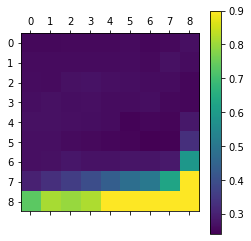

In [13]:
plt.matshow(error_mat)
plt.colorbar()
plt.show

### Answer to 4.1.1

The errors stayed fairly consistent until two hyperparameter's value largely increased (larger than 10). It is under the expectation as the larger the hyperparameters' value, the harsher the regularization. As two hyperparameters value increased, it essentially produced an over-regularizaed model which would reduce the performance at the situation when there are enough of data points. 

### Answer to 4.1.2

Make the variance hyperparameter $\lambda_{var}$ to infinity would change VAE back to basic autoencoder. 

As the variance hyperparameter become infinity, the variance predicted through encoder network can be nothing but 0 and essentially make the VAE encoder part only produce the mean, a fixed value.

## 4.2 Representation Learning Bakeoff
Below provides a skeleton of implementation. 
You may need to add several cells for your implementation. 

(TODO) Have fun and complete the requirements in 4.2! 
Don't forget to download your final predictions and to submit them.

###Find how many number of component for VAE would have most of the performance

In [6]:



cp_list = [2,5,10,20,50,100,300]
error_mat = np.zeros([len(cp_list)])

for i,cp in enumerate(cp_list):

    
    n_samples = 10000
    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]], dev_x_noisy,
        train_x_noisy, dev_x_noisy, test_x_noisy, n_components=cp,
        
    )


    #Uncomment following 3 lines if to use 10% labeled set for faster tuning
    best_error_dev, pred = linear_svm(
       z_vae_train[::10], train_y_noisy[::10], z_vae_dev, dev_y_noisy, z_vae_test
    )
    error_mat[i] = best_error_dev

Using VAE
Epoch: 1, train loss: 279.0130, dev loss: 218.7185
Epoch: 2, train loss: 207.8917, dev loss: 202.9041
Epoch: 3, train loss: 197.6972, dev loss: 196.7687
Epoch: 4, train loss: 192.8134, dev loss: 192.8363
Epoch: 5, train loss: 188.5478, dev loss: 189.1112
Epoch: 6, train loss: 185.5972, dev loss: 186.8270
Epoch: 7, train loss: 183.9605, dev loss: 185.7444
Epoch: 8, train loss: 183.2011, dev loss: 184.8069
Epoch: 9, train loss: 182.1698, dev loss: 184.1756
Epoch: 10, train loss: 181.4709, dev loss: 183.6211
Epoch: 11, train loss: 181.1700, dev loss: 183.0754
Epoch: 12, train loss: 180.7395, dev loss: 182.8161
Epoch: 13, train loss: 180.2811, dev loss: 182.5094
Epoch: 14, train loss: 179.8683, dev loss: 181.9145
Epoch: 15, train loss: 179.7139, dev loss: 181.9231
Performing linear SVM!
C = 0.010000, dev error = 0.738200
C = 0.100000, dev error = 0.724700
C = 1.000000, dev error = 0.723300
Selected classifier with best dev error 0.723300
Using VAE
Epoch: 1, train loss: 271.8900, 

In [8]:
cp_list = [400,600,700]
error_mat = np.zeros([len(cp_list)])

for i,cp in enumerate(cp_list):

    
    n_samples = 10000
    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]], dev_x_noisy,
        train_x_noisy, dev_x_noisy, test_x_noisy, n_components=cp,
        
    )


    #Uncomment following 3 lines if to use 10% labeled set for faster tuning
    best_error_dev, pred = linear_svm(
       z_vae_train[::10], train_y_noisy[::10], z_vae_dev, dev_y_noisy, z_vae_test
    )
    error_mat[i] = best_error_dev

Using VAE
Epoch: 1, train loss: 254.0080, dev loss: 218.4702
Epoch: 2, train loss: 202.3570, dev loss: 190.5425
Epoch: 3, train loss: 182.5468, dev loss: 177.9493
Epoch: 4, train loss: 172.6472, dev loss: 170.7821
Epoch: 5, train loss: 167.4880, dev loss: 166.6496
Epoch: 6, train loss: 163.6806, dev loss: 163.6055
Epoch: 7, train loss: 161.4121, dev loss: 162.2412
Epoch: 8, train loss: 159.7926, dev loss: 160.7936
Epoch: 9, train loss: 157.7912, dev loss: 158.6277
Epoch: 10, train loss: 156.7452, dev loss: 158.5321
Epoch: 11, train loss: 155.7535, dev loss: 157.0231
Epoch: 12, train loss: 154.5127, dev loss: 156.0015
Epoch: 13, train loss: 153.5947, dev loss: 155.1189
Epoch: 14, train loss: 152.5749, dev loss: 154.1008
Epoch: 15, train loss: 152.3818, dev loss: 153.8948
Performing linear SVM!
C = 0.010000, dev error = 0.198800
C = 0.100000, dev error = 0.164100
C = 1.000000, dev error = 0.155500
Selected classifier with best dev error 0.155500
Using VAE
Epoch: 1, train loss: 254.1154, 

In [9]:
cp_list = [250,300,350]
error_mat = np.zeros([len(cp_list)])

for i,cp in enumerate(cp_list):

    
    n_samples = 10000
    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]], dev_x_noisy,
        train_x_noisy, dev_x_noisy, test_x_noisy, n_components=cp,
        
    )


    #Uncomment following 3 lines if to use 10% labeled set for faster tuning
    best_error_dev, pred = linear_svm(
       z_vae_train[::10], train_y_noisy[::10], z_vae_dev, dev_y_noisy, z_vae_test
    )
    error_mat[i] = best_error_dev

Using VAE
Epoch: 1, train loss: 253.0883, dev loss: 215.2683
Epoch: 2, train loss: 198.3687, dev loss: 189.0641
Epoch: 3, train loss: 178.8964, dev loss: 175.2566
Epoch: 4, train loss: 169.3737, dev loss: 168.9749
Epoch: 5, train loss: 164.4960, dev loss: 165.4630
Epoch: 6, train loss: 160.9401, dev loss: 161.9197
Epoch: 7, train loss: 158.5013, dev loss: 159.4276
Epoch: 8, train loss: 156.1276, dev loss: 157.7469
Epoch: 9, train loss: 154.6902, dev loss: 156.6075
Epoch: 10, train loss: 153.5315, dev loss: 154.8079
Epoch: 11, train loss: 151.6914, dev loss: 153.6307
Epoch: 12, train loss: 150.3910, dev loss: 151.9194
Epoch: 13, train loss: 148.9911, dev loss: 151.2421
Epoch: 14, train loss: 147.7822, dev loss: 149.6762
Epoch: 15, train loss: 146.1636, dev loss: 148.2580
Performing linear SVM!
C = 0.010000, dev error = 0.195300
C = 0.100000, dev error = 0.158900
C = 1.000000, dev error = 0.153500
Selected classifier with best dev error 0.153500
Using VAE
Epoch: 1, train loss: 253.6805, 

In [17]:
kkl_list = [0.01,0.1,0.5,1,2,3,5,10]
kv_list = [0.01,0.1,0.5,1,2,3,5,10]
error_mat = np.zeros([len(kkl_list),len(kv_list)])

for i,kkl in enumerate(kkl_list):
  for j,kv in enumerate(kv_list):
    print(kkl,kv)
    n_samples = 10000
    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]], dev_x_noisy,
        train_x_noisy, dev_x_noisy, test_x_noisy, n_components=300,
        kkl=kkl, kv=kv
    )


    #Uncomment following 3 lines if to use 10% labeled set for faster tuning
    best_error_dev, pred = linear_svm(
       z_vae_train[::10], train_y_noisy[::10], z_vae_dev, dev_y_noisy, z_vae_test
    )
    error_mat[i,j] = best_error_dev

0.01 0.01
Using VAE
Epoch: 1, train loss: 210.2494, dev loss: 138.2778
Epoch: 2, train loss: 115.2040, dev loss: 102.1174
Epoch: 3, train loss: 93.0082, dev loss: 90.7407
Epoch: 4, train loss: 84.6965, dev loss: 83.6743
Epoch: 5, train loss: 80.5245, dev loss: 80.5005
Epoch: 6, train loss: 77.3032, dev loss: 78.3098
Epoch: 7, train loss: 75.7216, dev loss: 77.4211
Epoch: 8, train loss: 73.9619, dev loss: 75.8921
Epoch: 9, train loss: 72.8444, dev loss: 75.4580
Epoch: 10, train loss: 71.9759, dev loss: 73.6633
Epoch: 11, train loss: 71.2145, dev loss: 73.1681
Epoch: 12, train loss: 70.6057, dev loss: 72.6245
Epoch: 13, train loss: 70.3605, dev loss: 72.1733
Epoch: 14, train loss: 69.4071, dev loss: 71.7594
Epoch: 15, train loss: 69.0698, dev loss: 71.2869
Performing linear SVM!
C = 0.010000, dev error = 0.193500
C = 0.100000, dev error = 0.178700
C = 1.000000, dev error = 0.186200
Selected classifier with best dev error 0.178700
0.01 0.1
Using VAE
Epoch: 1, train loss: 214.2192, dev los

### Comment on VAE:
VAE have the best performance when reconstruct the data points to 300 dimensions with $\lambda_{KL}$, $\lambda_{var}$ is 1, 0.5 respectively, given error rate of 0.145.

### Anwser to 4.2.1:
First use VAE to reduce the noise and reconstruct the datasets. Then apply PCA to reduce dimension for classification.

In [21]:
def my_classify_emb(
        train_sub, dev_subset, train_data, dev_data, test_data, n_components_1,
        n_components_2):
    """
    Note: You may change input/output of this as you wish, depending on the  
          method you choose and your implementation.
    ------
    Input:
        train_sub, dev_subset: training and tuning data of my method
        train_data, dev_data, test_data: training/dev/test set, where my method 
            is used to extract features
        n_components: int, feature dimension
    Output:
        train_features, dev_features, test_features: extracted features of the 
        training/dev/test set
    """
    print("Using My Method!")
    
    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_sub, dev_subset,train_data, dev_data, test_data, n_components_1,
        kkl=1, kv=0.5
    )



    pca_1 = decomposition.PCA(n_components=n_components_2)
    pca_1.fit(z_vae_train)
    train_features = pca_1.transform(z_vae_train)
    dev_features=pca_1.transform(z_vae_dev)
    test_features = pca_1.transform(z_vae_test) 


    return train_features, dev_features, test_features


### Tunning Hyperparameter of my emb
First VAE, then PCA

In [13]:
n_samples = 10000
train_sub = train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]]

cp1_list=[300,400,500,600,780]

error_mat_list = []

# train your dimensionality reduction methods

for i,cp1 in enumerate(cp1_list):
  cp2_list=[i2 for i2 in range(100,cp1+1,100)]
  error_mat= np.zeros([len(cp2_list)])
  for j,cp2 in enumerate(cp2_list):
    z_my_train, z_my_dev, z_my_test = my_classify_emb(
        train_sub, dev_x_noisy, train_x_noisy, dev_x_noisy, 
        test_x_noisy, n_components_1=cp1, n_components_2=cp2
    )

  
    # train SVM
    error_mat[j], pred = linear_svm(
        z_my_train[::10], train_y_noisy[::10], z_my_dev, dev_y_noisy, z_my_test
    )
  error_mat_list.append(error_mat)

Using My Method!
Using VAE
Epoch: 1, train loss: 253.2994, dev loss: 217.7405
Epoch: 2, train loss: 202.1212, dev loss: 190.9312
Epoch: 3, train loss: 181.3155, dev loss: 177.2142
Epoch: 4, train loss: 171.3119, dev loss: 170.4150
Epoch: 5, train loss: 166.2357, dev loss: 166.1202
Epoch: 6, train loss: 162.2175, dev loss: 163.3267
Epoch: 7, train loss: 159.7527, dev loss: 160.6875
Epoch: 8, train loss: 157.8369, dev loss: 159.6035
Epoch: 9, train loss: 156.2980, dev loss: 157.9997
Epoch: 10, train loss: 154.6033, dev loss: 156.9380
Epoch: 11, train loss: 154.0533, dev loss: 155.6079
Epoch: 12, train loss: 153.0658, dev loss: 154.9110
Epoch: 13, train loss: 151.7876, dev loss: 153.9611
Epoch: 14, train loss: 151.0335, dev loss: 152.7552
Epoch: 15, train loss: 149.6058, dev loss: 151.9299
Performing linear SVM!
C = 0.010000, dev error = 0.203100
C = 0.100000, dev error = 0.172400
C = 1.000000, dev error = 0.170200
Selected classifier with best dev error 0.170200
Using My Method!
Using VA

### PCA alone performance

In [14]:
for cp2 in range(100,780,100):
    pca_1 = decomposition.PCA(n_components=cp2)
    pca_1.fit(train_x_noisy)
    z_pca_train = pca_1.transform(train_x_noisy)
    z_pca_dev=pca_1.transform(dev_x_noisy)
    z_pca_test = pca_1.transform(test_x_noisy) 
    error, pred = linear_svm(
          z_pca_train[::10], train_y_noisy[::10], z_pca_dev, dev_y_noisy, z_pca_test
        )

Performing linear SVM!
C = 0.010000, dev error = 0.232900
C = 0.100000, dev error = 0.226800
C = 1.000000, dev error = 0.227000
Selected classifier with best dev error 0.226800
Performing linear SVM!
C = 0.010000, dev error = 0.229300
C = 0.100000, dev error = 0.229600
C = 1.000000, dev error = 0.237200
Selected classifier with best dev error 0.229300
Performing linear SVM!
C = 0.010000, dev error = 0.229200
C = 0.100000, dev error = 0.236100
C = 1.000000, dev error = 0.263600
Selected classifier with best dev error 0.229200
Performing linear SVM!
C = 0.010000, dev error = 0.229200
C = 0.100000, dev error = 0.240000
C = 1.000000, dev error = 0.273000
Selected classifier with best dev error 0.229200
Performing linear SVM!
C = 0.010000, dev error = 0.229500
C = 0.100000, dev error = 0.239700
C = 1.000000, dev error = 0.275800
Selected classifier with best dev error 0.229500
Performing linear SVM!
C = 0.010000, dev error = 0.229300
C = 0.100000, dev error = 0.238800
C = 1.000000, dev erro

### First PCA, then VAE

In [15]:
def my_classify_emb_2(
        train_sub, dev_subset, train_data, dev_data, test_data, n_components_1,
        n_components_2):
    """
    Note: You may change input/output of this as you wish, depending on the  
          method you choose and your implementation.
    ------
    Input:
        train_sub, dev_subset: training and tuning data of my method
        train_data, dev_data, test_data: training/dev/test set, where my method 
            is used to extract features
        n_components: int, feature dimension
    Output:
        train_features, dev_features, test_features: extracted features of the 
        training/dev/test set
    """
    print("Using My Method!")
    
    pca_1 = decomposition.PCA(n_components=n_components_1)
    pca_1.fit(train_sub)
    train_sub = pca_1.transform(train_sub) 
    train_data = pca_1.transform(train_data)
    dev_data=pca_1.transform(dev_data)
    test_data = pca_1.transform(test_data) 
    z_vae_train, z_vae_dev, z_vae_test = vae_emb(
        train_sub, dev_data,train_data, dev_data, test_data, n_components_2
    )






    return z_vae_train, z_vae_dev, z_vae_test


In [16]:
_samples = 10000
train_sub = train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]]

cp1_list=[300,400,500,600,700]

error_mat_list = []

# train your dimensionality reduction methods

for i,cp1 in enumerate(cp1_list):
  cp2_list=[i2 for i2 in range(100,cp1+1,100)]
  error_mat= np.zeros([len(cp2_list)])
  for j,cp2 in enumerate(cp2_list):
    z_my_train, z_my_dev, z_my_test = my_classify_emb_2(
        train_sub, dev_x_noisy, train_x_noisy, dev_x_noisy, 
        test_x_noisy, n_components_1=cp1, n_components_2=cp2
    )



    # train SVM
    error_mat[j], pred = linear_svm(
        z_my_train[::10], train_y_noisy[::10], z_my_dev, dev_y_noisy, z_my_test
    )
  error_mat_list.append(error_mat)


Using My Method!
Using VAE
Epoch: 1, train loss: -3.3567, dev loss: -109.4077
Epoch: 2, train loss: -207.9897, dev loss: -321.4823
Epoch: 3, train loss: -401.2028, dev loss: -475.2338
Epoch: 4, train loss: -524.2405, dev loss: -580.4291
Epoch: 5, train loss: -612.5881, dev loss: -657.7108
Epoch: 6, train loss: -683.7684, dev loss: -704.1904
Epoch: 7, train loss: -734.2477, dev loss: -754.5937
Epoch: 8, train loss: -777.6613, dev loss: -785.7100
Epoch: 9, train loss: -811.8626, dev loss: -822.6609
Epoch: 10, train loss: -842.5292, dev loss: -853.3759
Epoch: 11, train loss: -866.2980, dev loss: -871.7608
Epoch: 12, train loss: -886.0412, dev loss: -892.9069
Epoch: 13, train loss: -909.0258, dev loss: -902.1154
Epoch: 14, train loss: -922.3479, dev loss: -939.9072
Epoch: 15, train loss: -936.2922, dev loss: -950.0546
Performing linear SVM!
C = 0.010000, dev error = 0.252400
C = 0.100000, dev error = 0.239000
C = 1.000000, dev error = 0.242500
Selected classifier with best dev error 0.2390

### Answer to 4.2.4:

PCA and VAE was implemented to reduce dimension provide features for SVM classification. VAE is chosen for it's ability to denoise the data, PCA is chosen as it is quick and straightforward method to reduce dimensions.

A total of 4 experiments are conducted. 

First, find out the best performance by VAE alone. The hyperparameters tuned are: dimensions, $\lambda_{KL}$, $\lambda_{var}$. Dimensions was first tuned alone with $\lambda_{KL}$, $\lambda_{var}$ both set to 1. The error rate is smallest(error = 0.147) when dimension = 300. Followed by tuning $\lambda_{KL}$, $\lambda_{var}$ together, by grid search, the best combination of $\lambda_{KL}$, $\lambda_{var}$ is 1, 0.5 respectively, given error rate of 0.145.

Second, find out the best performance by PCA alone. Dimensions range from 100 to 700. The change of dimensions did not heavily impact the the results as the error rate is consistently around 0.23.

Third, an experiment on the model which first conduct VAE on the data to reduce noise, then conduct PCA to reduce dimensions. Two hyperparameters here are tuned. The first hyperparameter is the dimension generated from VAE, and the second hyperparameter is the dimension generated from PCA. By grid search, With dimensions for VAE range from [300,780] and dimensions for PCA range from [100, dimensions of VAE], the combined model produced consistenly worse result then VAE model alone. The best performed combined model is when VAE dimensions = 300, PCA dimension = 200, error rate at 0.154, which is worse than VAE result alone (error rate 0.147)

Fourth, performed PCA first and VAE second with the same tunning method did in third experiment, the result is worse.

In conclusion, for the combination of VAE and PCA, VAE alone did the best, combined did second, PCA alone did the worst.

In [19]:
n_samples = train_x_noisy.shape[0]
z_vae_train, z_vae_dev, z_vae_test = vae_emb(
    train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]], dev_x_noisy,
    train_x_noisy, dev_x_noisy, test_x_noisy, n_components=300,
    kkl=1, kv=0.5
)


#Uncomment following 3 lines if to use 10% labeled set for faster tuning
best_error_dev, pred = linear_svm(
    z_vae_train, train_y_noisy, z_vae_dev, dev_y_noisy, z_vae_test
)

Using VAE
Epoch: 1, train loss: 118.0445, dev loss: 87.0227
Epoch: 2, train loss: 79.1600, dev loss: 73.9996
Epoch: 3, train loss: 66.6672, dev loss: 61.9332
Epoch: 4, train loss: 55.3873, dev loss: 52.3165
Epoch: 5, train loss: 47.8149, dev loss: 46.5051
Epoch: 6, train loss: 43.3668, dev loss: 43.0649
Epoch: 7, train loss: 40.5367, dev loss: 41.0294
Epoch: 8, train loss: 38.7833, dev loss: 39.3665
Epoch: 9, train loss: 37.4859, dev loss: 38.3621
Epoch: 10, train loss: 36.5619, dev loss: 37.7274
Epoch: 11, train loss: 35.9424, dev loss: 37.3215
Epoch: 12, train loss: 35.3834, dev loss: 36.4938
Epoch: 13, train loss: 34.9525, dev loss: 36.6542
Epoch: 14, train loss: 34.6370, dev loss: 36.0714
Epoch: 15, train loss: 34.3242, dev loss: 35.8912
Performing linear SVM!
C = 0.010000, dev error = 0.213600
C = 0.100000, dev error = 0.158600
C = 1.000000, dev error = 0.124200
Selected classifier with best dev error 0.124200


In [20]:
# Generate and download your submission
from google.colab import files
gen_solution(pred, "submission_vae.csv")
files.download('submission_vae.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
n_samples = train_x_noisy.shape[0]
train_sub = train_x_noisy[rpm(train_x_noisy.shape[0])[:n_samples]]



# train your dimensionality reduction methods


z_my_train, z_my_dev, z_my_test = my_classify_emb(
        train_sub, dev_x_noisy, train_x_noisy, dev_x_noisy, 
        test_x_noisy, n_components_1=300, n_components_2=200
    )

  
    # train SVM
best_error_dev, pred_my = linear_svm(
        z_my_train, train_y_noisy, z_my_dev, dev_y_noisy, z_my_test
    )


Using My Method!
Using VAE
Epoch: 1, train loss: 116.9724, dev loss: 86.4138
Epoch: 2, train loss: 78.4639, dev loss: 73.1404
Epoch: 3, train loss: 65.1921, dev loss: 60.5224
Epoch: 4, train loss: 54.3651, dev loss: 51.2771
Epoch: 5, train loss: 46.7569, dev loss: 45.5939
Epoch: 6, train loss: 42.2141, dev loss: 41.9706
Epoch: 7, train loss: 39.7502, dev loss: 40.0957
Epoch: 8, train loss: 38.1357, dev loss: 38.7628
Epoch: 9, train loss: 37.0419, dev loss: 37.8291
Epoch: 10, train loss: 36.3288, dev loss: 37.5464
Epoch: 11, train loss: 35.7076, dev loss: 36.9365
Epoch: 12, train loss: 35.2201, dev loss: 36.6927
Epoch: 13, train loss: 34.8528, dev loss: 36.2097
Epoch: 14, train loss: 34.5185, dev loss: 35.9267
Epoch: 15, train loss: 34.2280, dev loss: 35.6929
Performing linear SVM!
C = 0.010000, dev error = 0.205600
C = 0.100000, dev error = 0.153300
C = 1.000000, dev error = 0.123400
Selected classifier with best dev error 0.123400


In [23]:
gen_solution(pred_my, "submission_my.csv")
files.download('submission_my.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5 (TODO, optional) Extra Credit: Multiview Dimensionality Reduction

In [20]:
# Below are libraries that I (Freda) used in my solution, you may find some of 
#   them not necessary, depending on libraries you imported and whatnot. You 
#   are not required to use all of them.

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn import decomposition
from numpy.random import permutation as rpm
from plot import plot_images, plot_embedding, plot_embedding_annotation
from dataset import read_mnist, read_mnist_twoview
from utils import resize, x2p, JacobOptimizer, gen_solution
from svm import linear_svm
from vae import VAE

In [21]:
def kernel_p(data,p=2):
  #input data [n_point, n_dimensions]
  mat = data.dot(data.T)
  mat = (mat+1)**p
  return mat

In [22]:
def kernel_p_mm(data1,data2,p=2):
  #input data [n_point, n_dimensions]
  #calculate kernel between data1 and data2
  mat = data1.dot(data2.T)
  mat = (mat+1)**p
  return mat

In [23]:
def kcca_emb(train_sub1, train_sub2, train_data, dev_data, test_data, n_components,r1=1,r2=1):
    """
    TODO (optional, for extra credit): Train and extract feature with 
          (approximate) kernel CCA.
    Note: You may change input/output of this as you wish, depending on your 
          implementation.
    ------
    Input
        train_sub1, train_sub2: training data of view 1 and view 2
        train_data, dev_data, test_data: training/dev/test set on view1, where 
            trained KCCA is used to extract features
        n_components: int, feature dimension
    Output
        train_features, dev_features, test_features: extracted features on 
        view 1 of the training/dev/test set
    """
    #r1 and r2 are two tunning parameters
    Kx = kernel_p(train_sub1)
    Ky = kernel_p(train_sub2)

    Kxx = Kx.dot(Kx)+r1*np.identity(Kx.shape[0])
    Kyy = Ky.dot(Ky)+r2*np.identity(Ky.shape[0])
    Kxy = Kx.dot(Ky)
    Kyx = Ky.dot(Kx)
    S = np.linalg.inv(Kxx).dot(Kxy).dot(np.linalg.inv(Kyy)).dot(Kyx)
    eigenvalues, eigenvectors = np.linalg.eig(S)
    selected_indices = (-eigenvalues).argsort()[:n_components]
    Wx = eigenvectors[:, selected_indices]
    #Wy = np.linalg.inv(Kyy).dot(Kyx).dot(Wx)
    train_features = kernel_p_mm(train_data,train_sub1).dot(Wx)
    dev_features = kernel_p_mm(dev_data,train_sub1).dot(Wx)
    test_features = kernel_p_mm(test_data,train_sub1).dot(Wx)

    return train_features, dev_features, test_features

Data path is: ./data/noisy_two_view_distribute.mat


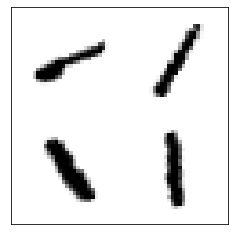

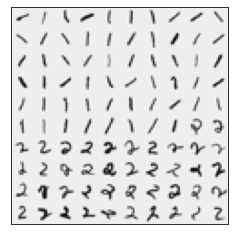

In [24]:
np.random.seed(1)

datapath="./data/noisy_two_view_distribute.mat"
print("Data path is: %s" % datapath)

trainData,devData,testData,testData2=read_mnist_twoview(datapath)
test_x_sample = testData
test_x_sample2 = testData2
test_x_image = np.reshape(
    test_x_sample, [test_x_sample.shape[0],28,28]).transpose(0, 2, 1)
test_x_image2 = np.reshape(
    test_x_sample2, [test_x_sample2.shape[0],28,28]).transpose(0, 2, 1)
train_x_sample = trainData.images
train_x_sample2 = trainData.images2
train_x_image = np.reshape(
    train_x_sample, [train_x_sample.shape[0],28,28]).transpose(0, 2, 1)
train_x_image2 = np.reshape(
    train_x_sample2, [train_x_sample2.shape[0],28,28]).transpose(0, 2, 1)
train_y_sample = np.reshape(trainData.labels, [train_x_sample.shape[0]])
dev_x_sample = devData.images
dev_x_sample2 = devData.images2
dev_x_image = np.reshape(
    dev_x_sample, [dev_x_sample.shape[0],28,28]).transpose(0, 2, 1)
dev_x_image2 = np.reshape(
    dev_x_sample2, [dev_x_sample2.shape[0],28,28]).transpose(0, 2, 1)
dev_y_sample = np.reshape(devData.labels, [dev_x_sample.shape[0]])

"""
1. Visualize a few input digits
"""
ax = plot_images(train_x_image[::1500], 2, 2, 28, 28)
plt.show()

"""
2. Visualize more input digits, using smaller scale
"""
train_x_rescale = resize(train_x_image,10,10)
ax = plot_images(train_x_rescale[::100], 10, 10, 10, 10)
plt.show()

### Tunning hyperparameter of KCCA

In [9]:
"""
3. Reduce dimension with KCCA
"""
n_components = 20

n_samples = 50
ran_idx = rpm(train_x_sample.shape[0])[:n_samples]
train_sub1 = train_x_sample[ran_idx]
train_sub2 = train_x_sample2[ran_idx]

z_train, z_dev, z_test = kcca_emb(
    train_sub1, train_sub2, train_x_sample, 
    dev_x_sample, test_x_sample, n_components
)

"""
4. Classify with SVM based on KCCA features
"""
cca_best_error_dev, cca_pred = linear_svm(
    z_train, train_y_sample, z_dev, dev_y_sample, z_test
)

Performing linear SVM!
C = 0.010000, dev error = 0.315200
C = 0.100000, dev error = 0.317100
C = 1.000000, dev error = 0.316700
Selected classifier with best dev error 0.315200


In [27]:
n_components = 20

n_samples = 100
ran_idx = rpm(train_x_sample.shape[0])[:n_samples]
train_sub1 = train_x_sample[ran_idx]
train_sub2 = train_x_sample2[ran_idx]

r1_list = [0.01,0.1,1,10]
r2_list = [0.01,0.1,1,10]

error_mat = np.full([len(r1_list),len(r2_list)],np.inf)

for i,r1 in enumerate(r1_list):
  for j, r2 in enumerate(r2_list):
    z_train, z_dev, z_test = kcca_emb(
        train_sub1, train_sub2, train_x_sample, 
        dev_x_sample, test_x_sample, n_components,
        r1 = r1, r2=r2
    )

    """
    4. Classify with SVM based on KCCA features
    """
    error_mat[i,j], cca_pred = linear_svm(
        z_train, train_y_sample, z_dev, dev_y_sample, z_test
    )

Performing linear SVM!
C = 0.010000, dev error = 0.304900
C = 0.100000, dev error = 0.310800
C = 1.000000, dev error = 0.302900
Selected classifier with best dev error 0.302900
Performing linear SVM!
C = 0.010000, dev error = 0.291500
C = 0.100000, dev error = 0.290700
C = 1.000000, dev error = 0.286600
Selected classifier with best dev error 0.286600
Performing linear SVM!
C = 0.010000, dev error = 0.272900
C = 0.100000, dev error = 0.272800
C = 1.000000, dev error = 0.273600
Selected classifier with best dev error 0.272800
Performing linear SVM!
C = 0.010000, dev error = 0.315300
C = 0.100000, dev error = 0.315200
C = 1.000000, dev error = 0.314900
Selected classifier with best dev error 0.314900
Performing linear SVM!
C = 0.010000, dev error = 0.302500
C = 0.100000, dev error = 0.307600
C = 1.000000, dev error = 0.306900
Selected classifier with best dev error 0.302500
Performing linear SVM!
C = 0.010000, dev error = 0.299100
C = 0.100000, dev error = 0.301300
C = 1.000000, dev erro

In [28]:
ind = np.unravel_index(np.argmin(error_mat, axis=None), error_mat.shape)

In [29]:
ind

(0, 2)

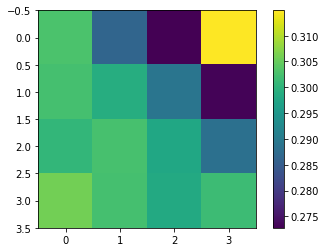

In [30]:
plt.imshow(error_mat)
plt.colorbar()

In [18]:


n_samples = 200
ran_idx = rpm(train_x_sample.shape[0])[:n_samples]
train_sub1 = train_x_sample[ran_idx]
train_sub2 = train_x_sample2[ran_idx]

nc_list = [20,40,80,100]

error_mat = np.full([len(nc_list)],np.inf)

for i,nc in enumerate(nc_list):
    z_train, z_dev, z_test = kcca_emb(
        train_sub1, train_sub2, train_x_sample, 
        dev_x_sample, test_x_sample, nc,
        
    )

    """
    4. Classify with SVM based on KCCA features
    """
    error_mat[i], cca_pred = linear_svm(
        z_train, train_y_sample, z_dev, dev_y_sample, z_test
    )

Performing linear SVM!
C = 0.010000, dev error = 0.296400
C = 0.100000, dev error = 0.295300
C = 1.000000, dev error = 0.286900
Selected classifier with best dev error 0.286900
Performing linear SVM!
C = 0.010000, dev error = 0.236700
C = 0.100000, dev error = 0.237100
C = 1.000000, dev error = 0.235300
Selected classifier with best dev error 0.235300
Performing linear SVM!
C = 0.010000, dev error = 0.157900
C = 0.100000, dev error = 0.156500
C = 1.000000, dev error = 0.156800
Selected classifier with best dev error 0.156500
Performing linear SVM!
C = 0.010000, dev error = 0.143700
C = 0.100000, dev error = 0.144100
C = 1.000000, dev error = 0.143600
Selected classifier with best dev error 0.143600


Text(0.5, 0, 'component size')

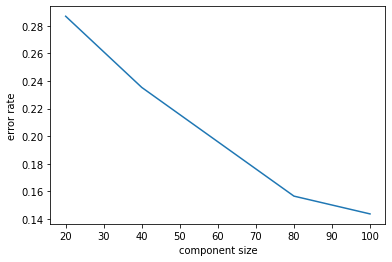

In [31]:
error_list = [0.2869,0.2353,0.1565,0.1436]
nc_list = [20,40,80,100]

plt.plot(nc_list, error_list)
plt.ylabel("error rate")
plt.xlabel('component size')

## Answer to 5.2
r1 and r2 has the best performance when r1=0.01 amd r2=1, for n_components, the bigger the components, the better the accuracy, however, it took way longer time to compute. Due to the limit of computational resources, I did not successfully find the ceiling of n_components when the error rate no longer dropping

### number of samples trade off experiment

In [25]:
n_components = 20

n_samples_list = [10,30,50,80,100]



error_mat = np.full([len(n_samples_list)],np.inf)

for i,n_samples in enumerate(n_samples_list):

    ran_idx = rpm(train_x_sample.shape[0])[:n_samples]
    train_sub1 = train_x_sample[ran_idx]
    train_sub2 = train_x_sample2[ran_idx]
    z_train, z_dev, z_test = kcca_emb(
        train_sub1, train_sub2, train_x_sample, 
        dev_x_sample, test_x_sample, n_components
    )

    """
    4. Classify with SVM based on KCCA features
    """
    error_mat[i], cca_pred = linear_svm(
        z_train, train_y_sample, z_dev, dev_y_sample, z_test
    )

Performing linear SVM!
C = 0.010000, dev error = 0.517500
C = 0.100000, dev error = 0.517700
C = 1.000000, dev error = 0.515700
Selected classifier with best dev error 0.515700
Performing linear SVM!
C = 0.010000, dev error = 0.308900
C = 0.100000, dev error = 0.310800
C = 1.000000, dev error = 0.314800
Selected classifier with best dev error 0.308900
Performing linear SVM!
C = 0.010000, dev error = 0.312900
C = 0.100000, dev error = 0.319600
C = 1.000000, dev error = 0.315200
Selected classifier with best dev error 0.312900
Performing linear SVM!
C = 0.010000, dev error = 0.299900
C = 0.100000, dev error = 0.306800
C = 1.000000, dev error = 0.311000
Selected classifier with best dev error 0.299900
Performing linear SVM!
C = 0.010000, dev error = 0.284400
C = 0.100000, dev error = 0.289200
C = 1.000000, dev error = 0.293200
Selected classifier with best dev error 0.284400


Text(0.5, 0, 'sample size')

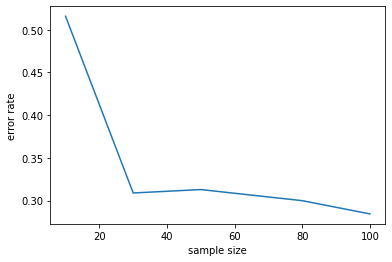

In [26]:
plt.plot(n_samples_list, error_mat)
plt.ylabel("error rate")
plt.xlabel('sample size')

# Export to PDF

In [45]:
from google.colab import drive, files
drive.mount('/content/drive')
# follow the prompt to mount your Google Drive to the Colab machine
! cp drive/MyDrive/Colab\ Notebooks/2021_ttic31220_hw2.ipynb ./
# Note: if you changed the path of your colab notebook in your Google Drive, 
# you might need to modify the above source path accordingly
! apt-get update
! apt-get install texlive texlive-xetex texlive-latex-extra pandoc
! pip install pypandoc
! jupyter nbconvert --to PDF "2021_ttic31220_hw2.ipynb"
files.download('2021_ttic31220_hw2.pdf')
# As a reminder, you will need to submit both the PDF file and this Jupyter 
#   notebook.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 ht

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>